u1up0ng: 20200620

<br><h1><center>In-building Detector Proof of Concept</center></h1>
### Import Libraries, Modules

In [1]:
# (These libraries were built up slowly)

# import standard libraries
import numpy as np
import pandas as pd
import random

# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# remove the warnings
plt.rc('figure', max_open_warning = 0) 

# import sklearn libraries 
from sklearn.utils import shuffle
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# imbalance data mitigation
from imblearn.over_sampling import SVMSMOTE

# results and metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, auc



### Gather and Asses Data

In [2]:
#random_state; 42 is the magic number
rs = np.random.RandomState(42)

# proprietary data was initally parsed, columns renamed
# load equipment dataset
# drop Serial Number as not yet needed
# random shuffle data and reset index

try:
    df = pd.read_csv('equipment_data_parsed.csv')
    df.drop(['SN'], axis= 1, inplace= True)
    df = shuffle(df, random_state = rs)
    df.reset_index(inplace= True, drop= True)
    print(f'Equipment dataset has {len(df)} samples with {df.shape[1]} features each.')

except:
    print("Dataset could not be loaded. Is the dataset missing?")

Equipment dataset has 76504 samples with 9 features each.


**Data Exploration**

In [3]:
# print last 10 data set
df.tail(10)

,meas_01,meas_02,meas_03,meas_04,meas_05,meas_06,meas_07,meas_08,building
76494,3,1,686,7,-104,-16,84,2178238,0
76495,8,4,816,8,-110,-15,1344,4567496,0
76496,14,15,890,4,-116,-20,378,4028628,0
76497,2,2,32,7,-105,-14,28,5550,0
76498,2,4,360,8,-121,-14,71,183691,1
76499,7,5,453,11,-96,-13,202,418219,0
76500,49,33,5948,10,-92,-12,1922,19760190,0
76501,5,2,1089,9,-99,-13,1407,5329813,0
76502,2,111,21962,9,-109,-11,11220,523169877,0
76503,21,15,5097,8,-106,-15,880,14332113,0


In [4]:
# print quick description of data
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meas_01,76504.0,1.309709e+01,1.964199e+01,1.0,3.0,6.0,16.0,8.360000e+02
meas_02,76504.0,1.301912e+01,5.889167e+01,1.0,2.0,5.0,12.0,1.212300e+04
meas_03,76504.0,9.395597e+03,4.340989e+04,0.0,339.0,1205.0,4030.0,1.517160e+06
meas_04,76504.0,9.124281e+00,2.405655e+00,0.0,8.0,9.0,11.0,1.500000e+01
meas_05,76504.0,-1.019726e+02,1.032421e+01,-141.0,-110.0,-104.0,-95.0,-5.600000e+01
meas_06,76504.0,-1.369552e+01,2.137862e+00,-28.0,-15.0,-14.0,-12.0,-3.000000e+00
meas_07,76504.0,1.449386e+03,5.421829e+03,1.0,158.0,429.0,1109.0,3.068930e+05
meas_08,76504.0,1.076665e+08,8.079700e+08,32.0,560502.0,5065254.0,41494875.5,9.439046e+10
building,76504.0,2.409809e-01,4.276815e-01,0.0,0.0,0.0,0.0,1.000000e+00


> **Data Description:**<br><br>
> The supplied data consist of all metrics readily available from the network, however it is pre-processed to anonymize the columns. Data is from a specific geographic area where building information were labeled. As mentioned earlier, ‘supervised learning’ will be used initially due to the presence of label. However, more importantly, the goal is to determine if supervised learning could provide a model with a high scoring metric. If achieved, it warrants further exploration of the data using the available metrics.<br><br>
> The csv file provided came from an exported raw data with some pre-processing. Data has a shape of 76,504 rows and 10 columns. The following are the high-level description of the columns and the underlying data:
- SN: unique id
- meas_01: integer, with a minimum value of 1 and a maximum value of 836
- meas_02: integer, with a minimum value of 1 and a maximum value of 12123
- meas_03: integDDer, with a minimum value of 0 and a maximum value of 1517160
- meas_04: integer, with a minimum value of 0 and a maximum value of 15
- meas_05: float, with a minimum value of -141 and a maximum value of -56
- meas_06: float, with a minimum value of -28 and a maximum value of -3
- meas_07: integer, with a minimum value of 1 and a maximum value of 306893
- meas_08: integer, with a minimum value of 32 and a maximum value of 94390460000
- building: this is the label; 1 means usage is done inside a building, else use is outdoor.


In [5]:
# determine data balance of target
print('Target Distribution in %:')
print(df['building'].value_counts(normalize=True)*100,'%')

Target Distribution in %:
0    75.901914
1    24.098086
Name: building, dtype: float64 %


> **Note:** The results above clearly shows imbalance in the target distribution. This has to be taken into account when before data is split into test and training datasets

In [6]:
#check for Nulls
print('Known Null Values: \n')
print(df.apply(lambda x: np.sum(x.isnull()) / len(df)))

Known Null Values: 

meas_01     0.0
meas_02     0.0
meas_03     0.0
meas_04     0.0
meas_05     0.0
meas_06     0.0
meas_07     0.0
meas_08     0.0
building    0.0
dtype: float64


**Exploratory Visualization**

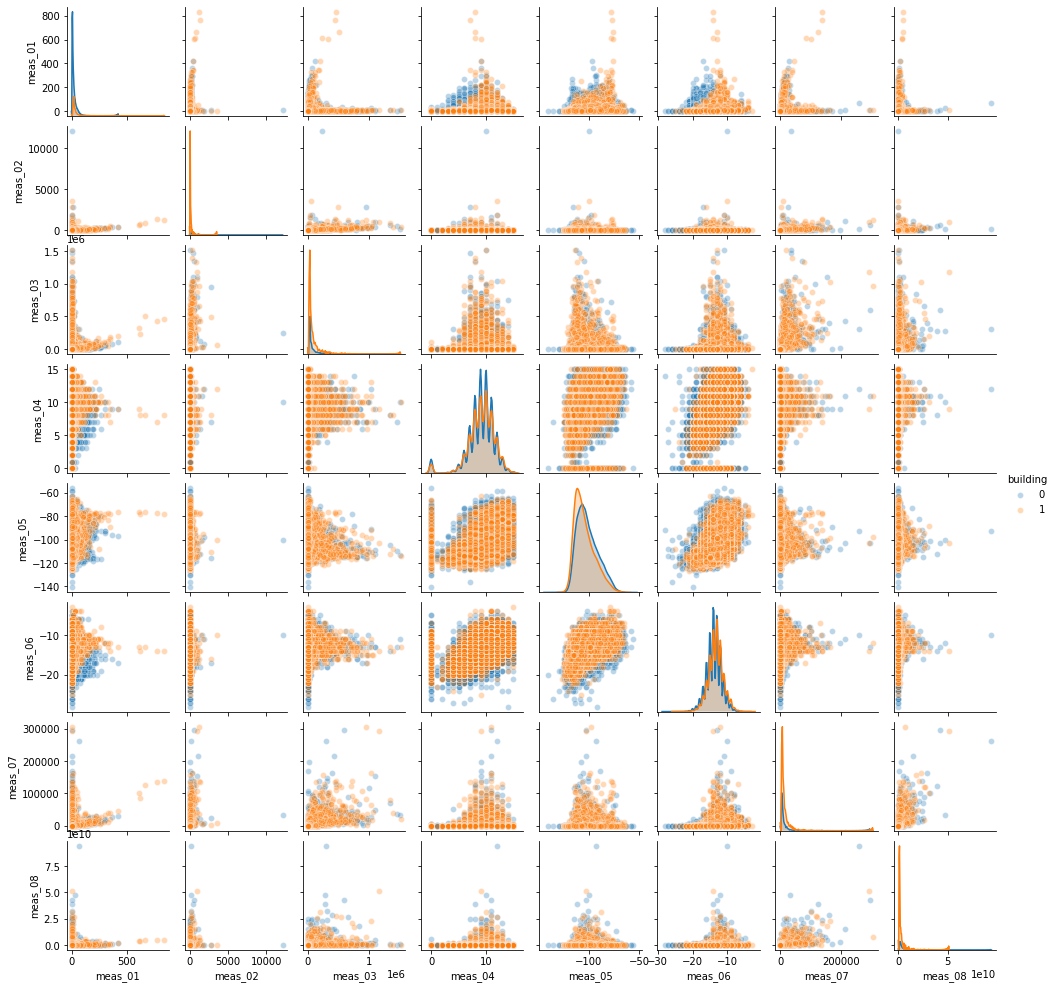

In [7]:
# Produce Scatter Matrix / Pairplot to undesrtand data description visually
sns.pairplot(df, hue= 'building', hue_order= [0, 1],
             height= 1.7, plot_kws= {'alpha': 0.3});

> The plot above and below clearly shows that most of the data are NOT distributed normally; but clearly has potentials for the study.

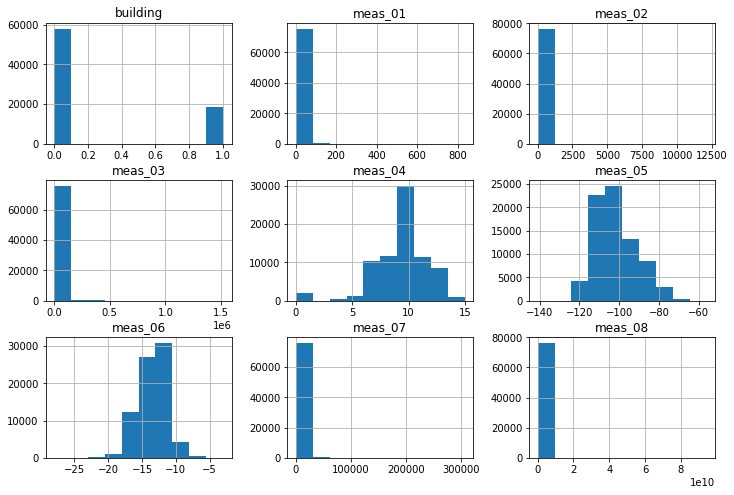

In [8]:
# Produce a quick histogram
(df.hist(figsize=(12,8)));

**Quick Data / Outliers Check**<br>


In [9]:
cols = (df.iloc[:,:-1]).columns
cols

Index(['meas_01', 'meas_02', 'meas_03', 'meas_04', 'meas_05', 'meas_06',
       'meas_07', 'meas_08'],
      dtype='object')

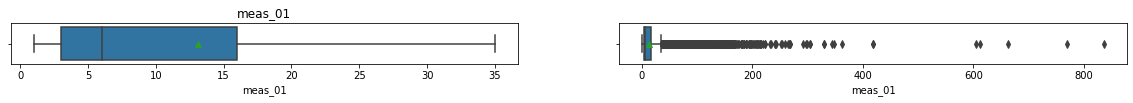

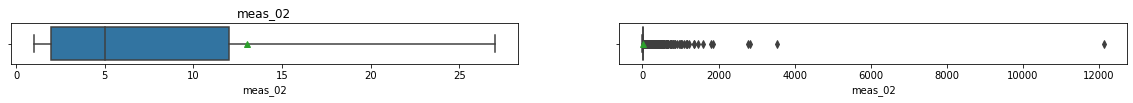

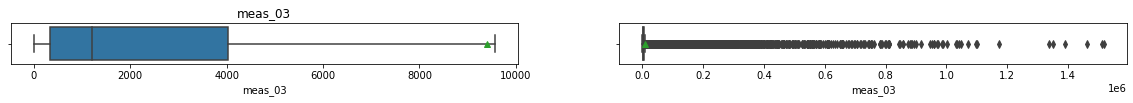

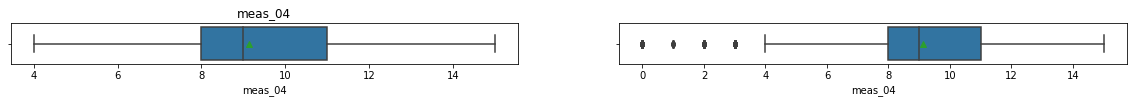

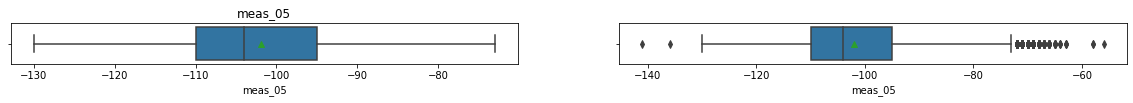

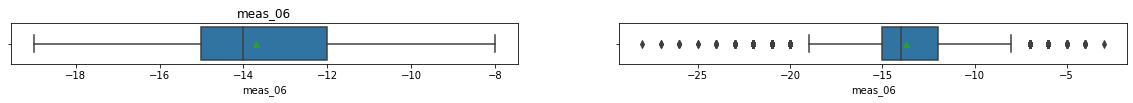

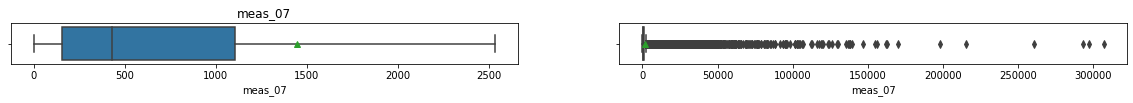

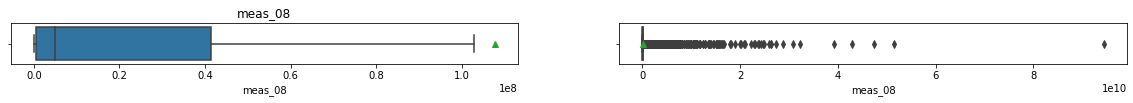

In [10]:
# Produce Box plots to check for normality
# show boxplot with and  without outliers

# define step for outlier detection 
out_step = 1.5

# quick boxplots for outliers
for i in cols:
    fig, (ax1, ax2)= plt.subplots(1,2, figsize=(20, 0.75))
    sns.boxplot(df[i], orient = 'h', showmeans=True, showfliers=False,
                ax =ax1, whis=out_step).set_title(i)
    sns.boxplot(df[i], orient= 'h', showmeans=True,
                ax = ax2, whis= out_step);

> Boxplot above clearly shows need for outlier cleanup

### Pre-process Data
>On an earlier version, outlier cleanup was done ahead of transform.<br> This version produced better outlier cleanup.

**Feature Scaling: Power Transform**

In [11]:
# PowerTransform relevant columns

# Use yeo-johnson (vs box-cox) since it is more suited on negative numbers
ct = ColumnTransformer([('dum_col',PowerTransformer(method ='yeo-johnson'), cols)],
                       remainder='passthrough')

#create scaled df
df01 = pd.DataFrame(ct.fit_transform(df), columns = df.columns)

In [12]:
df01.tail(10)

,meas_01,meas_02,meas_03,meas_04,meas_05,meas_06,meas_07,meas_08,building
76494,-0.654071,-1.407509,-0.284400,-1.019376,-0.078267,-1.075484,-1.101393,-0.283854,0.0
76495,0.247268,-0.159671,-0.198382,-0.613739,-0.774366,-0.617763,0.785733,-0.037434,0.0
76496,0.723515,0.941951,-0.155288,-1.996662,-1.576656,-2.861904,-0.061765,-0.079747,0.0
76497,-1.023160,-0.805510,-1.765800,-1.019376,-0.187303,-0.154952,-1.876590,-2.017993,0.0
76498,-1.023160,-0.159671,-0.602390,-0.613739,-2.333188,-0.154952,-1.219532,-1.054227,1.0
76499,0.128034,0.044137,-0.489361,0.830549,0.700495,0.313350,-0.490682,-0.806632,0.0
76500,1.621523,1.449436,0.798392,0.311933,1.031744,0.787608,1.019552,0.472833,0.0
76501,-0.179281,-0.805510,-0.054940,-0.169719,0.427328,0.313350,0.815804,0.014892,0.0
76502,-1.023160,2.021894,1.465714,-0.169719,-0.651227,1.268367,2.139632,1.732615,0.0
76503,1.040704,0.941951,0.720129,-0.613739,-0.299074,-0.617763,0.505972,0.358284,0.0


<br>**Outliers Cleanup**

In [13]:
# create list of all outliers
all_outliers  = []

# For each feature find the data points with extreme high or low values
for i in cols:
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile((df01.iloc[:,:-1])[i], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile((df01.iloc[:,:-1])[i], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3-Q1)
    
    # Display the outliers
    outliers = ((df01.iloc[:,1:])[~(((df01.iloc[:,:-1])[i] >= Q1 - step) 
                                       & ((df01.iloc[:,:-1])[i] <= Q3 + step))])
    #display(outliers)
    all_outliers += outliers.index.tolist()  

In [14]:
# Remove the outliers, if any were specified
df01 = df01.drop(df01.index[all_outliers]).reset_index(drop = True)

In [15]:
# check number of outliers removed
x = len(df) - len(df01)
print(f'Total of {x} outliers removed')

Total of 2883 outliers removed


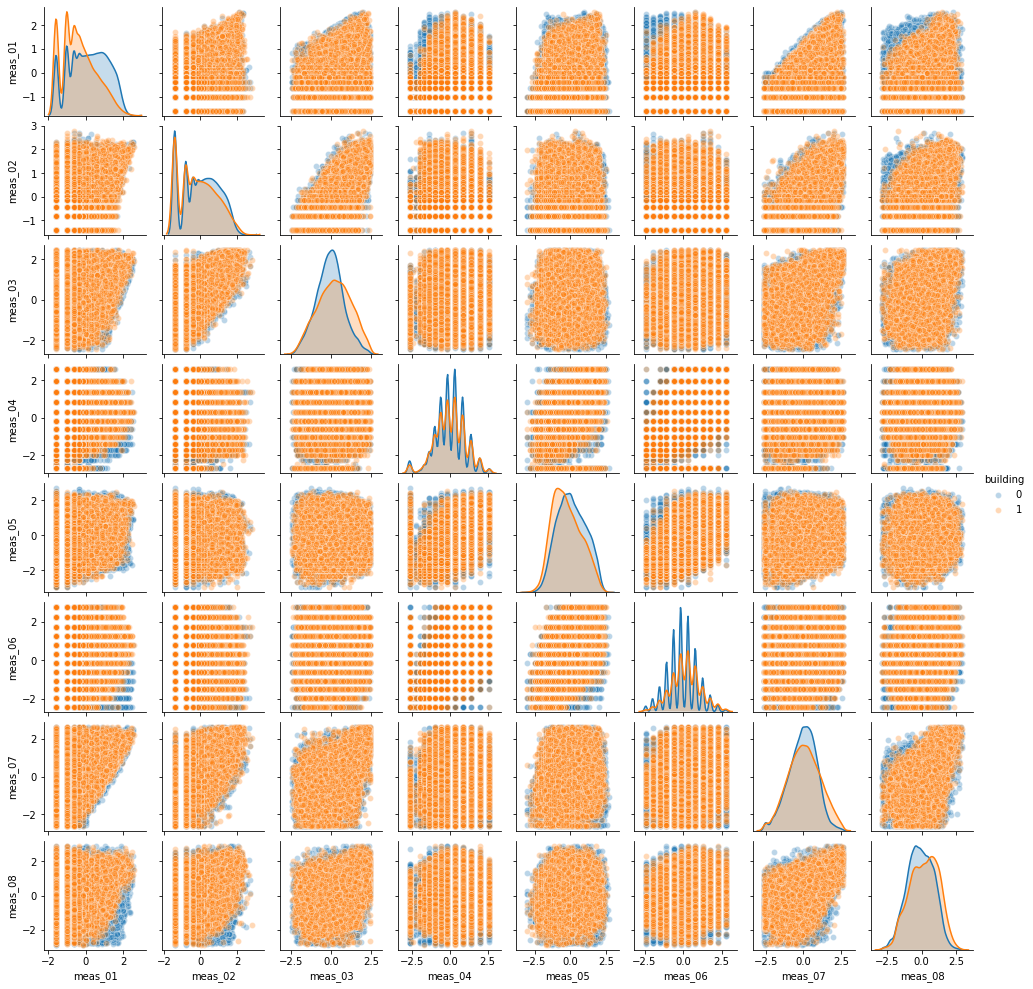

In [16]:
# check data see if ready to go
sns.pairplot(df01, hue= 'building', hue_order=[0, 1],
             height= 1.7, plot_kws = {'alpha': 0.3});

> The plot above shows a more Gaussian distribution of data

<br> **Oversampling using [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#smote-variants)**<br>
**Manage imbalance data; this data imbalance is a property of the problem domain.**

In [17]:
X = df01.drop('building', axis = 1)
y = df01['building']

# use smote svm to manage imbalance
svms = SVMSMOTE(random_state=rs)
X, y = svms.fit_resample(X, y)

In [18]:
# get frequency counts of the oversampled target column
y.value_counts()

1.0    56272
0.0    56272
Name: building, dtype: int64

> looks like data is ready to go for ml implementaion

### ML Implementation
**Establish Training and Test Data** 

In [19]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

In [20]:
# Show the results of the split
print(f'Training set has {X_train.shape[0]} samples.')
print(f'Testing set has {X_test.shape[0]} samples.')

Training set has 78780 samples.
Testing set has 33764 samples.


In [21]:
# create result helper function
def print_metrics(y_true, preds, name):
    '''
    INPUT:
    y_true = the y values that are actually true in the dataset (numpy array or pandas series)
    preds = the predictions for those values from some model (numpy array or pandas series)
    name = model name

    OUTPUT:
    prints the Confusion Matrix, Classification Results, and AUROC 
    '''
    
    #print confusion matrix
    print(f'Confusion Matrix: \n {confusion_matrix(y_true, preds)}')
    
    #print classification results
    print(f'\n Classification Results: \n {classification_report(y_true, preds)}')
        
    # AUROC Score
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, preds)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(f'AUROC score for {name} = {roc_auc}')

**Benchmark Model: Logistic Regression** 

In [22]:
# Train and Fit model
lrm = LogisticRegression()
lrm.fit(X_train,y_train)

LogisticRegression()

In [23]:
# Predict Model
lrmpredict = lrm.predict(X_test)

In [24]:
print_metrics(y_test,lrmpredict, 'LogisticRegression')

Confusion Matrix: 
 [[12346  4556]
 [ 5283 11579]]

 Classification Results: 
               precision    recall  f1-score   support

         0.0       0.70      0.73      0.72     16902
         1.0       0.72      0.69      0.70     16862

    accuracy                           0.71     33764
   macro avg       0.71      0.71      0.71     33764
weighted avg       0.71      0.71      0.71     33764

AUROC score for LogisticRegression = 0.7085690355817186


> unoptimized model does not look too bad, but can be improved

**Build ML Model:**<br>
**Random Forest Classifier; Hyper-parameter optimized**

In [25]:
#create parameters

# split data and shuffle
cv_sets = ShuffleSplit(random_state = rs, n_splits= 10)

# number of iterarions
iters = 50

the following code was used for hyper-parameter optimization, but was made a markdown after best parameters were found.
```python
# build a Random Forest Classifier model
rfcmodel = RandomForestClassifier(random_state = rs)

# Use Randomized Search Cross Validation to tune hyper parameters
# Set up the hyperparameter search
param_dist = {'n_estimators'      : list(range(260, 270, 2)),
              'max_depth'         : list(range(29, 32)),
              'max_features'      : list(range(2, 4)),
              'min_samples_split' : list(range(2, 4)),
              'min_samples_leaf'  : list(range(1, 3)),
              'bootstrap'         : [True, False],
              'criterion'         : ['gini', 'entropy']
              }

# Run a  search over the hyperparameters
random_search = RandomizedSearchCV(rfcmodel,
                                   # n = -3, # less 2 CPUS
                                   n_iter = iters,
                                   param_distributions=param_dist,
                                   cv = cv_sets,
                                   random_state = rs)

# Fit the model on the training data
random_search.fit(X_train, y_train)

# Make predictions on the test data
rfcpredict = random_search.best_estimator_.predict(X_test)

#find best parameters
print('Best Parameters: \n', random_search.best_params_, '\n')

# print metrics
print_metrics(y_test, rfcpredict)
```

**Optimized Random Forest Classifier Model**

In [26]:
# build a Random Forest classifier from parameters above
rfcmodel = RandomForestClassifier(n_estimators= 266,
                                  min_samples_split= 2,
                                  min_samples_leaf= 1,
                                  max_features= 2,
                                  max_depth= 30, 
                                  criterion= 'gini', 
                                  bootstrap= False,
                                  random_state = rs)

# Fit the model on the training data
rfcmodel.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=30, max_features=2,
                       n_estimators=266,
                       random_state=RandomState(MT19937) at 0x284F627C8C8)

In [27]:
# Predict test data
rfcpredict = rfcmodel.predict(X_test)

In [28]:
print_metrics(y_test, rfcpredict, 'RandomForestClassifier')

Confusion Matrix: 
 [[14688  2214]
 [ 2600 14262]]

 Classification Results: 
               precision    recall  f1-score   support

         0.0       0.85      0.87      0.86     16902
         1.0       0.87      0.85      0.86     16862

    accuracy                           0.86     33764
   macro avg       0.86      0.86      0.86     33764
weighted avg       0.86      0.86      0.86     33764

AUROC score for RandomForestClassifier = 0.8574083624900195


Not so bad !!<br>
u1upong